# Brain Cancer Data

We begin with the `BrainCancr` data set, which is part of the `ISLR2` package.

In [1]:
library(ISLR2)

The rows index the 88 patiens, while the columns contain the 8 predictors.

In [2]:
names(BrainCancer)

[1] "sex"       "diagnosis" "loc"       "ki"        "gtv"       "stereo"   
[7] "status"    "time"

We first briefly examine the data.

In [3]:
attach(BrainCancer)
table(sex)

sex
Female   Male 
    45     43 

In [4]:
table(diagnosis)

diagnosis
Meningioma  LG glioma  HG glioma      Other 
        42          9         22         14 

In [5]:
table(status)

status
 0  1 
53 35 

Before beginning an analysis, it is important to know how the `status` variable has been coded. Most software, including `R`, uses the convention that `status = 1` indicates an uncensored observation, and `status = 0` indicates a censored observation. But some scientists might use the opposite coding. For the `BrainCancer` data set 35 patients died before the end of the study.  
To begin the analysis, we re-create the Kaplan-Meier survival curve shown in Figure 11.2, using the `survfit()` function within the `R survival` library. Here `time` corresponds to $y_i$, the time to the _i_ th event (either censoring or death).

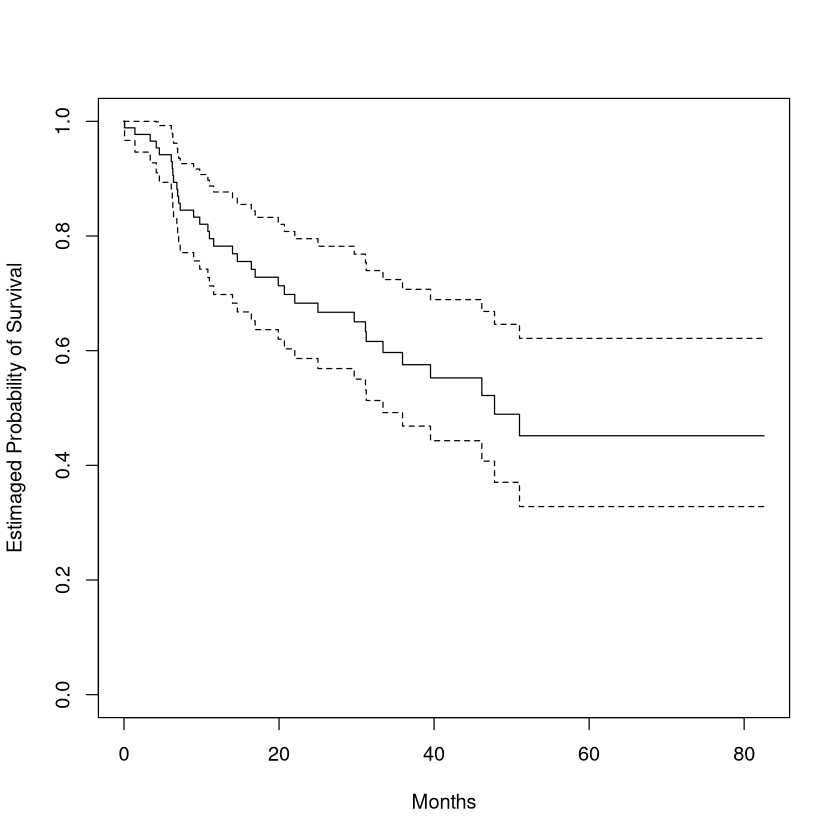

In [6]:
library(survival)
fit.surv <- survfit(Surv(time, status) ~ 1)
plot(fit.surv, xlab = "Months",
     ylab = "Estimaged Probability of Survival")

Next we create Kaplan-Meier survival curves that are stratified by `sex`, in order to reproduce Figure 11.3.

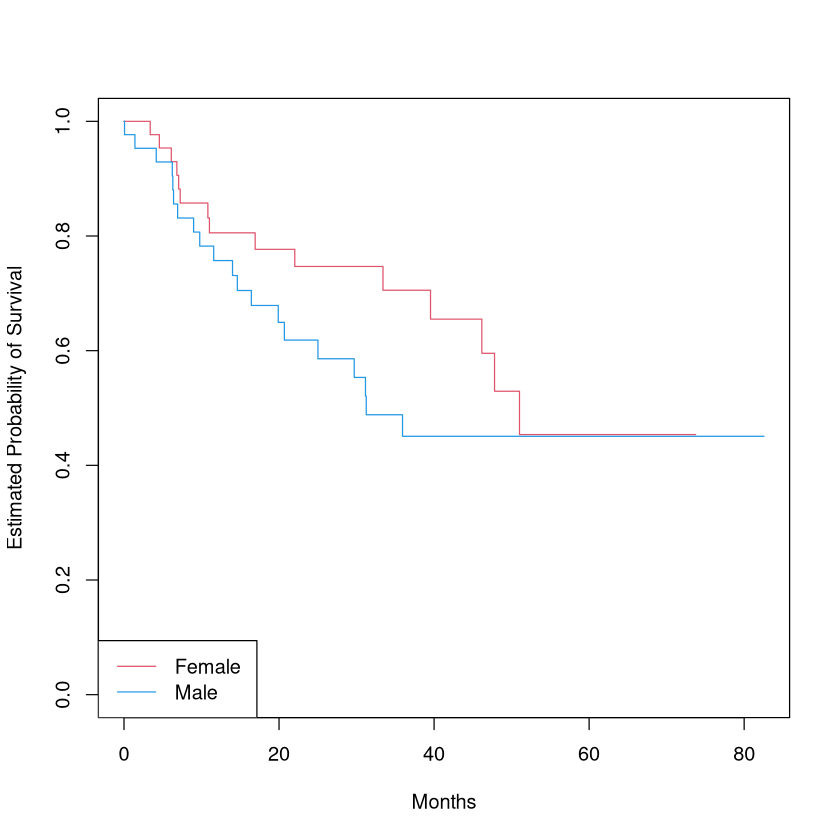

In [7]:
fit.sex <- survfit(Surv(time, status) ~ sex)
plot(fit.sex, xlab = "Months",
     ylab = "Estimated Probability of Survival", col = c(2,4))
legend("bottomleft", levels(sex), col = c(2,4), lty = 1)

As discussed in Section 11.4, we can perform a log-rank test to compare the survival of males to females, using the `survdiff()` function.

In [8]:
logrank.test <- survdiff(Surv(time, status) ~ sex)
logrank.test

Call:
survdiff(formula = Surv(time, status) ~ sex)

            N Observed Expected (O-E)^2/E (O-E)^2/V
sex=Female 45       15     18.5     0.676      1.44
sex=Male   43       20     16.5     0.761      1.44

 Chisq= 1.4  on 1 degrees of freedom, p= 0.2 

The resulting _p_-value is $0.2$, indicating no evidence of a difference in survival between the two sexes.  
Next, we fit Cox proportional hazards models using the `coxph()` function. To begin, we consider a model that uses `sex` as the only predictor.

In [9]:
fit.cox <- coxph(Surv(time, status) ~ sex)
summary(fit.cox)

Call:
coxph(formula = Surv(time, status) ~ sex)

  n= 88, number of events= 35 

          coef exp(coef) se(coef)     z Pr(>|z|)
sexMale 0.4077    1.5033   0.3420 1.192    0.233

        exp(coef) exp(-coef) lower .95 upper .95
sexMale     1.503     0.6652     0.769     2.939

Concordance= 0.565  (se = 0.045 )
Likelihood ratio test= 1.44  on 1 df,   p=0.2
Wald test            = 1.42  on 1 df,   p=0.2
Score (logrank) test = 1.44  on 1 df,   p=0.2


Note that the values of the likelihood ratio, Wald, and score tests have been rounded. It is possible to display additional digits.

In [10]:
summary(fit.cox)$logtest[1]

test 
1.438822

In [11]:
summary(fit.cox)$waldtest[1]

test 
1.42

In [12]:
summary(fit.cox)$sctest[1]

test 
1.440495

Regardless of which test we use, we see that there is no clear evidence for a difference in survival between males and females.

In [13]:
logrank.test$chisq

[1] 1.440495

As we learned in this chapter, the score test from the Cox model is exactly equal to the log rank test statistic!  
Now we fit a model that makes use of additional predictors.

In [14]:
fit.all <- coxph(
    Surv(time, status) ~ sex + diagnosis + loc + ki + gtv + stereo)
fit.all

Call:
coxph(formula = Surv(time, status) ~ sex + diagnosis + loc + 
    ki + gtv + stereo)

                       coef exp(coef) se(coef)      z        p
sexMale             0.18375   1.20171  0.36036  0.510  0.61012
diagnosisLG glioma  0.91502   2.49683  0.63816  1.434  0.15161
diagnosisHG glioma  2.15457   8.62414  0.45052  4.782 1.73e-06
diagnosisOther      0.88570   2.42467  0.65787  1.346  0.17821
locSupratentorial   0.44119   1.55456  0.70367  0.627  0.53066
ki                 -0.05496   0.94653  0.01831 -3.001  0.00269
gtv                 0.03429   1.03489  0.02233  1.536  0.12466
stereoSRT           0.17778   1.19456  0.60158  0.296  0.76760

Likelihood ratio test=41.37  on 8 df, p=1.776e-06
n= 87, number of events= 35 
   (1 observation deleted due to missingness)

The `diagnosis` variable has been coded so that the baseline corresponds to meningioma. The results indicate that the risk associated with HG glioma is more than eight times (i.e. $e^{2.15} = 8.62$) the risk associated with meningioma. In other words, after adjusting for the other predictors, patients with HG glioma have much worse survival compared to those with meningioma. In addition, larger values of the Karnofsky index, `ki`, are associated with lower risk, i.e. longer survival.  
Finally, we plot survival curves for each diagnosis category, adjusting for the other predictors. To make these plots, we set the values of the other predictors equal to the mean for quantitative variables, and the modal value for factors. We first create a data frame with four rows, one for each level of diagnosis. The `survfit()` function will produce a curve for each of the rows in this data frame, and one call to `plot()` will display them all in the same plot.

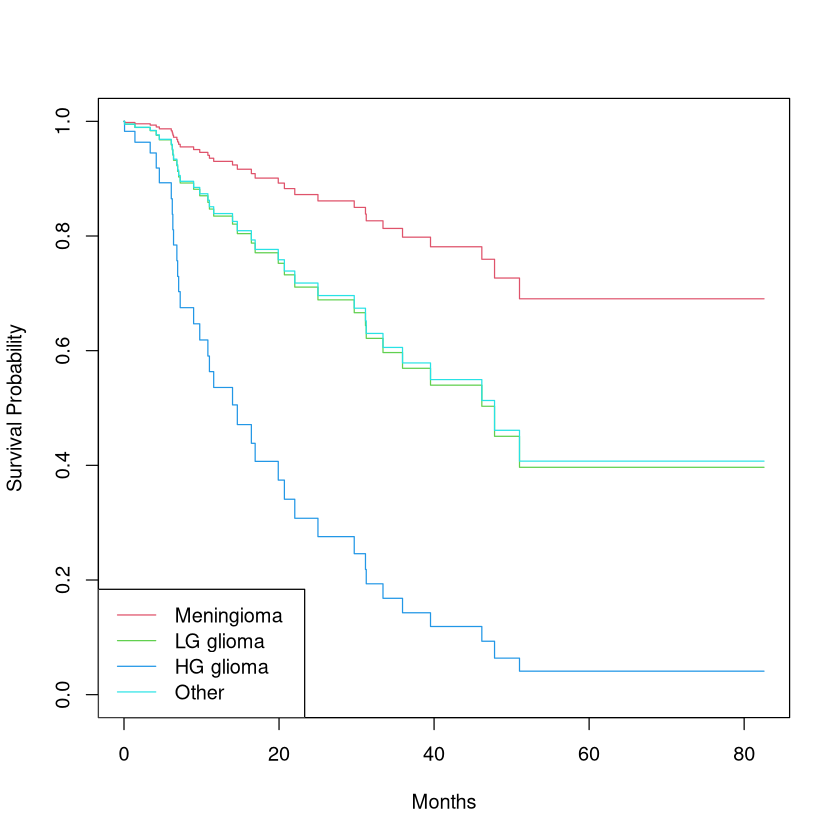

In [15]:
modaldata <- data.frame(
    diagnosis = levels(diagnosis),
    sex = rep("Female", 4),
    loc = rep("Supratentorial", 4),
    ki = rep(mean(ki), 4),
    gtv = rep(mean(gtv), 4),
    stereo = rep("SRT", 4)
    )
survplots <- survfit(fit.all, newdata = modaldata)
plot(survplots, xlab = "Months",
     ylab = "Survival Probability", col = 2:5)
legend("bottomleft", levels(diagnosis), col = 2:5, lty = 1)